In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch_npu
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device=torch.device('npu')
train_data = pd.read_csv('/aistor/aispeech/hpc_stor01/home/xuruoxi00sx/ttt/daily_train.csv')
test_data = pd.read_csv('/aistor/aispeech/hpc_stor01/home/xuruoxi00sx/ttt/daily_test.csv')

# 选择特征和目标列
# features = ['season', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
features = [
    "Global_reactive_power", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3",
    "sub_metering_remainder", "Voltage", "Global_intensity", "RR",
    "NBJRR1", "NBJRR5", "NBJRR10", "NBJBROU"
]
target = "Global_active_power"

# 参数定义
look_back = 90
T =365  
batch_size = 256
epochs = 300
learn_rate = 0.0001
input_dim = len(features)
hidden_dim = 128
num_layers = 8
dropout = 0.2
device=torch.device('npu')
# 数据预处理：归一化
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

train_data[features] = scaler_features.fit_transform(train_data[features])
train_data[target] = scaler_target.fit_transform(train_data[[target]])
test_data[features] = scaler_features.transform(test_data[features])
test_data[target] = scaler_target.transform(test_data[[target]])

train_data[features] = train_data[features].fillna(train_data[features].mean())
test_data[features] = test_data[features].fillna(test_data[features].mean())

# 构建时间序列数据（包含前90步和后90步特征）
def create_sequences_with_future_features(data, features, target, look_back, pred_len):
    X, y = [], []
    for i in range(0, len(data) - look_back - pred_len, look_back):
        # 前90步特征
        X_past = data[features].iloc[i:i + look_back].values
        # 后90步特征
        X_future = data[features].iloc[i + look_back:i + look_back + pred_len].values
        # 拼接前后特征：形状 [180, feature_dim]
        X_combined = np.concatenate([X_past, X_future], axis=0)
        y_seq = data[target].iloc[i + look_back:i + look_back + pred_len].values
        X.append(X_combined)
        y.append(y_seq)
    return np.array(X), np.array(y)

# 构造数据
X_train, y_train = create_sequences_with_future_features(train_data, features, target, look_back, T)
X_test, y_test = create_sequences_with_future_features(test_data, features, target, look_back, T)

# 转换为 PyTorch Tensor 
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 构建数据加载器
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class Linear(nn.Module):
    def __init__(self, seq_len, pred_len, feature_dim):
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.feature_dim = feature_dim
        # 对每个特征单独做线性变换
        self.linear = nn.ModuleList([nn.Linear(seq_len, pred_len) for _ in range(feature_dim)])

    def forward(self, x):
        # x: [B, seq_len, feature_dim]
        outs = []
        for i, linear_layer in enumerate(self.linear):
            xi = x[:, :, i]  # [B, seq_len]
            outi = linear_layer(xi)  # [B, pred_len]
            outs.append(outi.unsqueeze(-1))
        out = torch.cat(outs, dim=-1)  # [B, pred_len, feature_dim]
        out = out.mean(dim=-1)  # [B, pred_len]
        return out
model = Linear(seq_len=look_back+T, pred_len=T, feature_dim=input_dim).to(device)

def init_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

model.apply(init_weights)

# 损失函数与优化器
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learn_rate)

# 梯度裁剪函数
def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# 训练模型
train_losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        if torch.isnan(loss):
            raise ValueError("Loss became NaN during training.")

        loss.backward()
        clip_gradients(model)
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

/usr/local/python3.10.15/lib/python3.10/site-packages/torch_npu/utils/collect_env.py:59: UserWarning: Warning: The /usr/local/Ascend/ascend-toolkit/latest owner does not match the current owner.
  warnings.warn(f"Warning: The {path} owner does not match the current owner.")
/usr/local/python3.10.15/lib/python3.10/site-packages/torch_npu/utils/collect_env.py:59: UserWarning: Warning: The /usr/local/Ascend/ascend-toolkit/8.0.0/aarch64-linux/ascend_toolkit_install.info owner does not match the current owner.
  warnings.warn(f"Warning: The {path} owner does not match the current owner.")
/usr/local/python3.10.15/lib/python3.10/site-packages/torch_npu/__init__.py:248: UserWarning: On the interactive interface, the value of TASK_QUEUE_ENABLE is set to 0 by default.                      Do not set it to 1 to prevent some unknown errors
  warnings.warn("On the interactive interface, the value of TASK_QUEUE_ENABLE is set to 0 by default. \


Epoch [20/300], Loss: 0.0214
Epoch [40/300], Loss: 0.0106
Epoch [60/300], Loss: 0.0060
Epoch [80/300], Loss: 0.0033
Epoch [100/300], Loss: 0.0018
Epoch [120/300], Loss: 0.0010
Epoch [140/300], Loss: 0.0005
Epoch [160/300], Loss: 0.0003
Epoch [180/300], Loss: 0.0001
Epoch [200/300], Loss: 0.0001
Epoch [220/300], Loss: 0.0000
Epoch [240/300], Loss: 0.0000
Epoch [260/300], Loss: 0.0000
Epoch [280/300], Loss: 0.0000
Epoch [300/300], Loss: 0.0000


mse: 368807.45234375
mae: 478.42277426719664


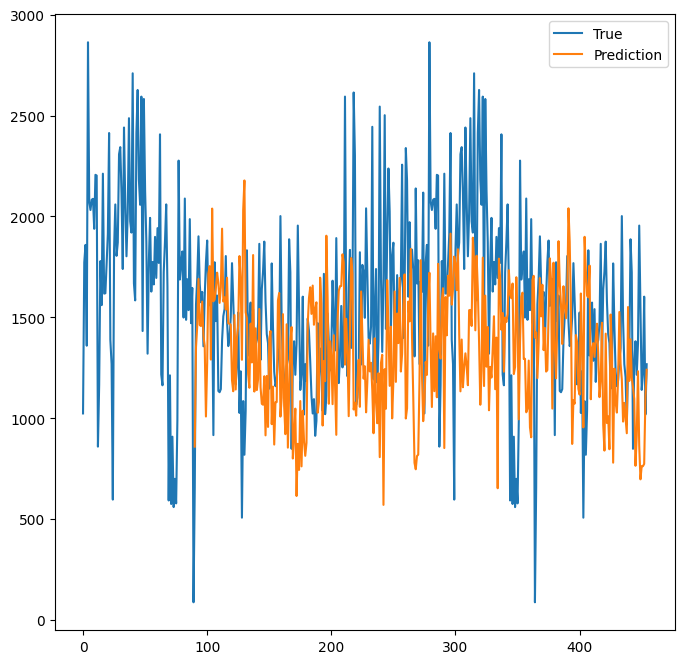

In [2]:
# 测试
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())


predictions = (np.array(predictions).reshape(-1, 1))
actuals = (np.array(actuals).reshape(-1, 1))

# 反归一化
predictions = scaler_target.inverse_transform(predictions)
actuals = scaler_target.inverse_transform(actuals)

best_i = -1
mse = float('inf')
mse_list = []
mae_list = []
for i in range(90,len(actuals)-T):
    tmp = mean_absolute_error(actuals[i:i+T], predictions[i:i+T])
    # print(actuals[i][:1],predictions[i][:1])
    mae_list.append(tmp)
    mse_list.append(mean_squared_error(actuals[i:i+T], predictions[i:i+T]))
    if tmp < mse:
        mse = tmp
        best_i = i
# print(len(mse_list))
# print(len(mae_list))
print('mse:', sum(mse_list)/len(mse_list))
print('mae:', sum(mae_list)/len(mae_list))

i = best_i
# i=107
y1 = np.concatenate((actuals[i-90:i], actuals[i:i+T]))
y2 = predictions[i:i+T]
# print(len(actuals[i-90:i]),len(y1),len(y2))
# 计算两条曲线的 x 轴范围
x1 = np.arange(len(y1))  # x1: [0, 1, 2, 3]
x2 = np.arange(len(y1) - len(y2), len(y1))  # x2: [2, 3]
plt.figure(figsize=(8, 8))
# 绘制曲线
plt.plot(x1, y1, label="True")  # 第一条曲线
plt.plot(x2, y2, label="Prediction")  # 第二条曲线

# 添加图例和标题
plt.legend()

# plt.xlabel("X")
# plt.ylabel("Y")
# plt.savefig("img/output_linear_long_.png")
# 显示图形
plt.show()

In [3]:
i

627